# Montar las carpetas de google drive.
# Create environment in Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


# Funciones para ejecutar el código

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224       

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [6]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [9]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}

dataframes_path = 'melanoma_without_duplicates_separated_50/'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [12]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [13]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [14]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "Pesos Vgg16/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [15]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'vgg16'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [17]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.features.0.weight
	 cnn.features.0.bias
	 cnn.features.1.weight
	 cnn.features.1.bias
	 cnn.features.3.weight
	 cnn.features.3.bias
	 cnn.features.4.weight
	 cnn.features.4.bias
	 cnn.features.7.weight
	 cnn.features.7.bias
	 cnn.features.8.weight
	 cnn.features.8.bias
	 cnn.features.10.weight
	 cnn.features.10.bias
	 cnn.features.11.weight
	 cnn.features.11.bias
	 cnn.features.14.weight
	 cnn.features.14.bias
	 cnn.features.15.weight
	 cnn.features.15.bias
	 cnn.features.17.weight
	 cnn.features.17.bias
	 cnn.features.18.weight
	 cnn.features.18.bias
	 cnn.features.20.weight
	 cnn.features.20.bias
	 cnn.features.21.weight
	 cnn.features.21.bias
	 cnn.features.24.weight
	 cnn.features.24.bias
	 cnn.features.25.weight
	 cnn.features.25.bias
	 cnn.features.27.weight
	 cnn.features.27.bias
	 cnn.features.28.weight
	 cnn.features.28.bias
	 cnn.features.30.weight
	 cnn.features.30.bias
	 cnn.features.31.weight
	 cnn.features.31.bias
	 cnn.features.34.weight
	 cnn.feat

100%|██████████| 17/17 [02:33<00:00,  9.02s/it]


Epoch:  0 Train Loss: 0.72020701 AUC: 0.25911458 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [02:35<00:00,  9.16s/it]


Epoch: 0 Val Loss: 0.71890691 AUC: 0.37307692 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch:  1 Train Loss: 0.71734754 AUC: 0.40625000 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


Epoch: 1 Val Loss: 0.71574312 AUC: 0.33846154 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch:  2 Train Loss: 0.71372194 AUC: 0.46025641 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 2 Val Loss: 0.71247657 AUC: 0.38589744 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:19<00:00,  1.18s/it]


Epoch:  3 Train Loss: 0.70951254 AUC: 0.69985775 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 3 Val Loss: 0.70803154 AUC: 0.48333333 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch:  4 Train Loss: 0.69995736 AUC: 0.90340136 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 4 Val Loss: 0.69452173 AUC: 0.55384615 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch:  5 Train Loss: 0.67662868 AUC: 0.81760204 
[[1. 0.]
 [1. 0.]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 5 Val Loss: 0.67889302 AUC: 0.69358974 
[[9.996997e-01 3.003003e-04]
 [1.000000e+00 0.000000e+00]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch:  6 Train Loss: 0.64248640 AUC: 0.92820513 
[[0.9948427  0.0051573 ]
 [0.95790331 0.04209669]]


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


Epoch: 6 Val Loss: 0.66693196 AUC: 0.72307692 
[[0.96936937 0.03063063]
 [0.93115646 0.06884354]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch:  7 Train Loss: 0.61417036 AUC: 0.81901042 
[[0.9765343  0.0234657 ]
 [0.87048479 0.12951521]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 7 Val Loss: 0.66141734 AUC: 0.73205128 
[[0.93941441 0.06058559]
 [0.86619048 0.13380952]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch:  8 Train Loss: 0.60584853 AUC: 0.86224490 
[[0.96590453 0.03409547]
 [0.80988593 0.19011407]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 8 Val Loss: 0.65644382 AUC: 0.71923077 
[[0.91951952 0.08048048]
 [0.81608466 0.18391534]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch:  9 Train Loss: 0.59973760 AUC: 0.82682292 
[[0.95740072 0.04259928]
 [0.75855513 0.24144487]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 9 Val Loss: 0.65445538 AUC: 0.74358974 
[[0.90468468 0.09531532]
 [0.77638095 0.22361905]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 10 Train Loss: 0.59518840 AUC: 0.94993412 
[[0.95208402 0.04791598]
 [0.71534739 0.28465261]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 10 Val Loss: 0.65743510 AUC: 0.77307692 
[[0.89352989 0.10647011]
 [0.74614719 0.25385281]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 11 Train Loss: 0.59121678 AUC: 0.92179487 
[[0.94735259 0.05264741]
 [0.67839037 0.32160963]]


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch: 11 Val Loss: 0.65754144 AUC: 0.75000000 
[[0.87882883 0.12117117]
 [0.71253968 0.28746032]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 12 Train Loss: 0.59823020 AUC: 0.85633001 
[[0.94307137 0.05692863]
 [0.64931266 0.35068734]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 12 Val Loss: 0.65565307 AUC: 0.76923077 
[[0.86597367 0.13402633]
 [0.6829304  0.3170696 ]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 13 Train Loss: 0.59568241 AUC: 0.95238095 
[[0.93965962 0.06034038]
 [0.62357414 0.37642586]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 13 Val Loss: 0.66762432 AUC: 0.76538462 
[[0.86113256 0.13886744]
 [0.67360544 0.32639456]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 14 Train Loss: 0.59250003 AUC: 0.91570881 
[[0.93706378 0.06293622]
 [0.60126743 0.39873257]]


100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch: 14 Val Loss: 0.64864302 AUC: 0.76025641 
[[0.85165165 0.14834835]
 [0.64711111 0.35288889]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 15 Train Loss: 0.58664547 AUC: 0.87088274 
[[0.93456679 0.06543321]
 [0.57854087 0.42145913]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 15 Val Loss: 0.65237117 AUC: 0.75384615 
[[0.84842342 0.15157658]
 [0.63511905 0.36488095]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 16 Train Loss: 0.59260617 AUC: 0.89016603 
[[0.93130176 0.06869824]
 [0.55983002 0.44016998]]


100%|██████████| 17/17 [00:10<00:00,  1.67it/s]


Epoch: 16 Val Loss: 0.66244445 AUC: 0.68333333 
[[0.84525702 0.15474298]
 [0.62666667 0.37333333]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 17 Train Loss: 0.59337948 AUC: 0.87088274 
[[0.9306057  0.0693943 ]
 [0.54721166 0.45278834]]


100%|██████████| 17/17 [00:10<00:00,  1.61it/s]


Epoch: 17 Val Loss: 0.66304735 AUC: 0.72179487 
[[0.83893894 0.16106106]
 [0.61449735 0.38550265]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 18 Train Loss: 0.58124078 AUC: 0.96122995 
[[0.92979289 0.07020711]
 [0.53211927 0.46788073]]


100%|██████████| 17/17 [00:09<00:00,  1.80it/s]


Epoch: 18 Val Loss: 0.65272058 AUC: 0.80769231 
[[0.83537221 0.16462779]
 [0.60380952 0.39619048]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 19 Train Loss: 0.57971421 AUC: 0.86845466 
[[0.9301444  0.0698556 ]
 [0.51910646 0.48089354]]


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch: 19 Val Loss: 0.65435634 AUC: 0.73076923 
[[0.83198198 0.16801802]
 [0.59371429 0.40628571]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 20 Train Loss: 0.58234154 AUC: 0.94387755 
[[0.9297748  0.0702252 ]
 [0.50715191 0.49284809]]


100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


Epoch: 20 Val Loss: 0.65516909 AUC: 0.69230769 
[[0.83063063 0.16936937]
 [0.58730159 0.41269841]]


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


Epoch: 21 Train Loss: 0.57350710 AUC: 0.93741497 
[[0.93025927 0.06974073]
 [0.49541998 0.50458002]]


100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


Epoch: 21 Val Loss: 0.65155299 AUC: 0.77307692 
[[0.82858313 0.17141687]
 [0.57939394 0.42060606]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 22 Train Loss: 0.57741385 AUC: 0.87882653 
[[0.93030921 0.06969079]
 [0.48520417 0.51479583]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 22 Val Loss: 0.66116612 AUC: 0.74743590 
[[0.82726204 0.17273796]
 [0.57507246 0.42492754]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 23 Train Loss: 0.57760217 AUC: 0.91310160 
[[0.93005415 0.06994585]
 [0.47512674 0.52487326]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 23 Val Loss: 0.67157842 AUC: 0.74487179 
[[0.82004505 0.17995495]
 [0.56412698 0.43587302]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 24 Train Loss: 0.58046375 AUC: 0.91538462 
[[0.9298917  0.0701083 ]
 [0.46692015 0.53307985]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 24 Val Loss: 0.65082773 AUC: 0.73461538 
[[0.81772973 0.18227027]
 [0.5560381  0.4439619 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 25 Train Loss: 0.57957351 AUC: 0.86025641 
[[0.93008886 0.06991114]
 [0.45963732 0.54036268]]


100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch: 25 Val Loss: 0.65880854 AUC: 0.74230769 
[[0.81545392 0.18454608]
 [0.55098901 0.44901099]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 26 Train Loss: 0.57814737 AUC: 0.90256410 
[[0.92933547 0.07066453]
 [0.45085199 0.54914801]]


100%|██████████| 17/17 [00:09<00:00,  1.70it/s]


Epoch: 26 Val Loss: 0.66790572 AUC: 0.71282051 
[[0.81354688 0.18645312]
 [0.54751323 0.45248677]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 27 Train Loss: 0.57602146 AUC: 0.89677419 
[[0.92947396 0.07052604]
 [0.44371266 0.55628734]]


100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch: 27 Val Loss: 0.65990980 AUC: 0.74871795 
[[0.81081081 0.18918919]
 [0.54170068 0.45829932]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 28 Train Loss: 0.57798909 AUC: 0.90340136 
[[0.92997635 0.07002365]
 [0.43791792 0.56208208]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 28 Val Loss: 0.65018902 AUC: 0.74743590 
[[0.81006524 0.18993476]
 [0.53714286 0.46285714]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 29 Train Loss: 0.57730620 AUC: 0.82838710 
[[0.9299639  0.0700361 ]
 [0.43200253 0.56799747]]


100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


Epoch: 29 Val Loss: 0.64738480 AUC: 0.72435897 
[[0.80882883 0.19117117]
 [0.53155556 0.46844444]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 30 Train Loss: 0.57143332 AUC: 0.87820513 
[[0.93024339 0.06975661]
 [0.42567153 0.57432847]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 30 Val Loss: 0.65930509 AUC: 0.73589744 
[[0.80714908 0.19285092]
 [0.52774194 0.47225806]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 31 Train Loss: 0.56621738 AUC: 0.92857143 
[[0.93073105 0.06926895]
 [0.41914211 0.58085789]]


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch: 31 Val Loss: 0.65198335 AUC: 0.71923077 
[[0.80608108 0.19391892]
 [0.52404762 0.47595238]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 32 Train Loss: 0.57417627 AUC: 0.91225806 
[[0.93091565 0.06908435]
 [0.41398779 0.58601221]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 32 Val Loss: 0.66603904 AUC: 0.73717949 
[[0.80660661 0.19339339]
 [0.52513709 0.47486291]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 33 Train Loss: 0.57887423 AUC: 0.89102564 
[[0.93093013 0.06906987]
 [0.4099754  0.5900246 ]]


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch: 33 Val Loss: 0.65290523 AUC: 0.72820513 
[[0.80476948 0.19523052]
 [0.52039216 0.47960784]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 34 Train Loss: 0.56885445 AUC: 0.79557292 
[[0.93078907 0.06921093]
 [0.4038566  0.5961434 ]]


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch: 34 Val Loss: 0.65524761 AUC: 0.71282051 
[[0.80566281 0.19433719]
 [0.52016327 0.47983673]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 35 Train Loss: 0.56830999 AUC: 0.98451613 
[[0.93190935 0.06809065]
 [0.40029573 0.59970427]]


100%|██████████| 17/17 [00:09<00:00,  1.76it/s]


Epoch: 35 Val Loss: 0.65774548 AUC: 0.74871795 
[[0.80225225 0.19774775]
 [0.51306878 0.48693122]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 36 Train Loss: 0.56826184 AUC: 0.97935484 
[[0.93189579 0.06810421]
 [0.39512897 0.60487103]]


100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


Epoch: 36 Val Loss: 0.65526305 AUC: 0.71794872 
[[0.80204529 0.19795471]
 [0.51140283 0.48859717]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 37 Train Loss: 0.56461234 AUC: 0.95915679 
[[0.93197796 0.06802204]
 [0.38993396 0.61006604]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 37 Val Loss: 0.66542581 AUC: 0.76410256 
[[0.79943101 0.20056899]
 [0.50736842 0.49263158]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 38 Train Loss: 0.56734827 AUC: 0.92245989 
[[0.93233361 0.06766639]
 [0.38588281 0.61411719]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 38 Val Loss: 0.65139881 AUC: 0.71025641 
[[0.7986602  0.2013398 ]
 [0.50373626 0.49626374]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 39 Train Loss: 0.55849069 AUC: 0.95000000 
[[0.93294224 0.06705776]
 [0.38117871 0.61882129]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 39 Val Loss: 0.66190300 AUC: 0.73846154 
[[0.79626126 0.20373874]
 [0.49947619 0.50052381]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 40 Train Loss: 0.55795943 AUC: 0.96794872 
[[0.93365325 0.06634675]
 [0.37688955 0.62311045]]


100%|██████████| 17/17 [00:09<00:00,  1.75it/s]


Epoch: 40 Val Loss: 0.65272065 AUC: 0.73333333 
[[0.79494617 0.20505383]
 [0.4955633  0.5044367 ]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 41 Train Loss: 0.56172706 AUC: 0.94508301 
[[0.93433041 0.06566959]
 [0.37316676 0.62683324]]


100%|██████████| 17/17 [00:09<00:00,  1.74it/s]


Epoch: 41 Val Loss: 0.64805385 AUC: 0.77692308 
[[0.79390819 0.20609181]
 [0.49188209 0.50811791]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 42 Train Loss: 0.55876609 AUC: 0.93032258 
[[0.93464025 0.06535975]
 [0.36868866 0.63131134]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 42 Val Loss: 0.65413896 AUC: 0.78717949 
[[0.79279279 0.20720721]
 [0.48903654 0.51096346]]


100%|██████████| 17/17 [00:19<00:00,  1.18s/it]


Epoch: 43 Train Loss: 0.56006770 AUC: 0.99218750 
[[0.93468986 0.06531014]
 [0.36432769 0.63567231]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 43 Val Loss: 0.65777575 AUC: 0.77435897 
[[0.79066339 0.20933661]
 [0.48467532 0.51532468]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 44 Train Loss: 0.56072276 AUC: 0.97548387 
[[0.93513839 0.06486161]
 [0.36108999 0.63891001]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 44 Val Loss: 0.66918202 AUC: 0.69487179 
[[0.79031031 0.20968969]
 [0.48491005 0.51508995]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 45 Train Loss: 0.55865728 AUC: 0.90364583 
[[0.93576362 0.06423638]
 [0.35774508 0.64225492]]


100%|██████████| 17/17 [00:11<00:00,  1.48it/s]


Epoch: 45 Val Loss: 0.65414638 AUC: 0.70641026 
[[0.79012926 0.20987074]
 [0.48327122 0.51672878]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 46 Train Loss: 0.55865531 AUC: 0.97161290 
[[0.93624702 0.06375298]
 [0.35454251 0.64545749]]


100%|██████████| 17/17 [00:09<00:00,  1.81it/s]


Epoch: 46 Val Loss: 0.65582659 AUC: 0.73846154 
[[0.7893042  0.2106958 ]
 [0.48097264 0.51902736]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 47 Train Loss: 0.55551820 AUC: 0.91176471 
[[0.9368231  0.0631769 ]
 [0.35087928 0.64912072]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 47 Val Loss: 0.64827901 AUC: 0.78333333 
[[0.78787538 0.21212462]
 [0.47698413 0.52301587]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 48 Train Loss: 0.55526227 AUC: 0.96045918 
[[0.93733883 0.06266117]
 [0.34748196 0.65251804]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 48 Val Loss: 0.65395123 AUC: 0.74358974 
[[0.78760802 0.21239198]
 [0.47580175 0.52419825]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 49 Train Loss: 0.55097782 AUC: 0.96301020 
[[0.93812274 0.06187726]
 [0.3443346  0.6556654 ]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 49 Val Loss: 0.66025401 AUC: 0.73076923 
[[0.78673874 0.21326126]
 [0.47405714 0.52594286]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 50 Train Loss: 0.55299266 AUC: 0.96538462 
[[0.93859277 0.06140723]
 [0.34082606 0.65917394]]


100%|██████████| 17/17 [00:09<00:00,  1.76it/s]


Epoch: 50 Val Loss: 0.64876158 AUC: 0.76923077 
[[0.78714008 0.21285992]
 [0.4735014  0.5264986 ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 51 Train Loss: 0.55217175 AUC: 0.95182292 
[[0.93890586 0.06109414]
 [0.33741591 0.66258409]]


100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


Epoch: 51 Val Loss: 0.64988558 AUC: 0.77051282 
[[0.78610534 0.21389466]
 [0.47080586 0.52919414]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 52 Train Loss: 0.55039802 AUC: 0.97656250 
[[0.93954771 0.06045229]
 [0.33456489 0.66543511]]


100%|██████████| 17/17 [00:09<00:00,  1.84it/s]


Epoch: 52 Val Loss: 0.64790924 AUC: 0.79743590 
[[0.78517763 0.21482237]
 [0.46785265 0.53214735]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 53 Train Loss: 0.54891639 AUC: 0.93472222 
[[0.93999866 0.06000134]
 [0.33132657 0.66867343]]


100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


Epoch: 53 Val Loss: 0.65445949 AUC: 0.81282051 
[[0.78498498 0.21501502]
 [0.46687831 0.53312169]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 54 Train Loss: 0.55620079 AUC: 0.96173469 
[[0.9402363  0.0597637 ]
 [0.32865538 0.67134462]]


100%|██████████| 17/17 [00:11<00:00,  1.44it/s]


Epoch: 54 Val Loss: 0.65504935 AUC: 0.80256410 
[[0.78361998 0.21638002]
 [0.464      0.536     ]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 55 Train Loss: 0.55303917 AUC: 0.98469388 
[[0.94107788 0.05892212]
 [0.32669066 0.67330934]]


100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


Epoch: 55 Val Loss: 0.65196808 AUC: 0.76923077 
[[0.78272201 0.21727799]
 [0.46146259 0.53853741]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 56 Train Loss: 0.56503014 AUC: 0.96282051 
[[0.94087656 0.05912344]
 [0.32429458 0.67570542]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 56 Val Loss: 0.65264976 AUC: 0.77179487 
[[0.78397345 0.21602655]
 [0.46265664 0.53734336]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 57 Train Loss: 0.55338926 AUC: 0.99354839 
[[0.94146023 0.05853977]
 [0.32214501 0.67785499]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 57 Val Loss: 0.66008226 AUC: 0.75384615 
[[0.78257223 0.21742777]
 [0.46019704 0.53980296]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 58 Train Loss: 0.55035907 AUC: 0.96168582 
[[0.94202411 0.05797589]
 [0.31981053 0.68018947]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 58 Val Loss: 0.66013114 AUC: 0.76410256 
[[0.78173767 0.21826233]
 [0.45882163 0.54117837]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 59 Train Loss: 0.54596466 AUC: 0.96040868 
[[0.94253911 0.05746089]
 [0.31707858 0.68292142]]


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 59 Val Loss: 0.65120841 AUC: 0.75897436 
[[0.78162162 0.21837838]
 [0.45780952 0.54219048]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 60 Train Loss: 0.54776045 AUC: 0.98461538 
[[0.94300763 0.05699237]
 [0.31449854 0.68550146]]


100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


Epoch: 60 Val Loss: 0.65545646 AUC: 0.75128205 
[[0.78183429 0.21816571]
 [0.45767369 0.54232631]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 61 Train Loss: 0.54599563 AUC: 0.94508301 
[[0.94343193 0.05656807]
 [0.31200172 0.68799828]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 61 Val Loss: 0.65890139 AUC: 0.76025641 
[[0.78166231 0.21833769]
 [0.4572043  0.5427957 ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 62 Train Loss: 0.55114879 AUC: 0.90166028 
[[0.94367085 0.05632915]
 [0.30958416 0.69041584]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 62 Val Loss: 0.66315862 AUC: 0.81282051 
[[0.78040898 0.21959102]
 [0.4554195  0.5445805 ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 63 Train Loss: 0.54519957 AUC: 1.00000000 
[[0.94409973 0.05590027]
 [0.3069451  0.6930549 ]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 63 Val Loss: 0.65016543 AUC: 0.78076923 
[[0.78063063 0.21936937]
 [0.45482143 0.54517857]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 64 Train Loss: 0.54415519 AUC: 0.94508301 
[[0.9447098  0.0552902 ]
 [0.30482597 0.69517403]]


100%|██████████| 17/17 [00:11<00:00,  1.54it/s]


Epoch: 64 Val Loss: 0.64273377 AUC: 0.76538462 
[[0.7797921 0.2202079]
 [0.4516044 0.5483956]]


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


Epoch: 65 Train Loss: 0.53766359 AUC: 0.97948718 
[[0.94524669 0.05475331]
 [0.30196451 0.69803549]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 65 Val Loss: 0.65775819 AUC: 0.76923077 
[[0.77832378 0.22167622]
 [0.44906205 0.55093795]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 66 Train Loss: 0.54022563 AUC: 0.97135417 
[[0.94568673 0.05431327]
 [0.29941547 0.70058453]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 66 Val Loss: 0.64743657 AUC: 0.78205128 
[[0.77759849 0.22240151]
 [0.44668088 0.55331912]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 67 Train Loss: 0.54054248 AUC: 0.94636015 
[[0.94624655 0.05375345]
 [0.29716506 0.70283494]]


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch: 67 Val Loss: 0.64991129 AUC: 0.76025641 
[[0.777292  0.222708 ]
 [0.4454902 0.5545098]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 68 Train Loss: 0.53569693 AUC: 0.98589744 
[[0.94673782 0.05326218]
 [0.29440128 0.70559872]]


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 68 Val Loss: 0.64741090 AUC: 0.81410256 
[[0.77754276 0.22245724]
 [0.44502415 0.55497585]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 69 Train Loss: 0.53777880 AUC: 0.96168582 
[[0.94721506 0.05278494]
 [0.29187941 0.70812059]]


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch: 69 Val Loss: 0.65677449 AUC: 0.81025641 
[[0.77770914 0.22229086]
 [0.44511565 0.55488435]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 70 Train Loss: 0.54129078 AUC: 0.96923077 
[[0.94755174 0.05244826]
 [0.28974991 0.71025009]]


100%|██████████| 17/17 [00:09<00:00,  1.81it/s]


Epoch: 70 Val Loss: 0.66357957 AUC: 0.78717949 
[[0.77690648 0.22309352]
 [0.44423877 0.55576123]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 71 Train Loss: 0.53494312 AUC: 0.96173469 
[[0.9481799 0.0518201]
 [0.2874155 0.7125845]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 71 Val Loss: 0.65960281 AUC: 0.77820513 
[[0.77575075 0.22424925]
 [0.44246032 0.55753968]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 72 Train Loss: 0.53554732 AUC: 0.97435897 
[[0.94871668 0.05128332]
 [0.28519715 0.71480285]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 72 Val Loss: 0.64292927 AUC: 0.77692308 
[[0.77549056 0.22450944]
 [0.44052185 0.55947815]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 73 Train Loss: 0.53338449 AUC: 0.95019157 
[[0.9490682  0.0509318 ]
 [0.28260199 0.71739801]]


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch: 73 Val Loss: 0.64917395 AUC: 0.79102564 
[[0.7751887  0.2248113 ]
 [0.43912484 0.56087516]]


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


Epoch: 74 Train Loss: 0.53051923 AUC: 0.98461538 
[[0.94957882 0.05042118]
 [0.28020279 0.71979721]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 74 Val Loss: 0.64816746 AUC: 0.80128205 
[[0.77475075 0.22524925]
 [0.4375619  0.5624381 ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 75 Train Loss: 0.52924692 AUC: 0.99872286 
[[0.95000475 0.04999525]
 [0.27764158 0.72235842]]


100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch: 75 Val Loss: 0.65068907 AUC: 0.80769231 
[[0.77377904 0.22622096]
 [0.43528822 0.56471178]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 76 Train Loss: 0.52674922 AUC: 1.00000000 
[[0.95058371 0.04941629]
 [0.27507284 0.72492716]]


100%|██████████| 17/17 [00:09<00:00,  1.84it/s]


Epoch: 76 Val Loss: 0.64882076 AUC: 0.78974359 
[[0.77276237 0.22723763]
 [0.43277675 0.56722325]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 77 Train Loss: 0.53018817 AUC: 0.99341238 
[[0.95100898 0.04899102]
 [0.27276494 0.72723506]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 77 Val Loss: 0.65645377 AUC: 0.78333333 
[[0.77096327 0.22903673]
 [0.42932845 0.57067155]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 78 Train Loss: 0.53463297 AUC: 0.96923077 
[[0.95140063 0.04859937]
 [0.2706358  0.7293642 ]]


100%|██████████| 17/17 [00:10<00:00,  1.70it/s]


Epoch: 78 Val Loss: 0.65878572 AUC: 0.75192308 
[[0.76968868 0.23031132]
 [0.42714888 0.57285112]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 79 Train Loss: 0.53354598 AUC: 0.99354839 
[[0.9517148  0.0482852 ]
 [0.26853612 0.73146388]]


100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


Epoch: 79 Val Loss: 0.65398751 AUC: 0.76153846 
[[0.76900901 0.23099099]
 [0.4255     0.5745    ]]


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


Epoch: 80 Train Loss: 0.53181848 AUC: 0.98850575 
[[0.95213264 0.04786736]
 [0.26648829 0.73351171]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 80 Val Loss: 0.65640512 AUC: 0.78333333 
[[0.76874652 0.23125348]
 [0.42473839 0.57526161]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 81 Train Loss: 0.53137341 AUC: 0.93148880 
[[0.95258431 0.04741569]
 [0.26437448 0.73562552]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 81 Val Loss: 0.64222129 AUC: 0.77692308 
[[0.76886399 0.23113601]
 [0.4239489  0.5760511 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 82 Train Loss: 0.53172724 AUC: 0.99744572 
[[0.95291636 0.04708364]
 [0.26238032 0.73761968]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 82 Val Loss: 0.64777434 AUC: 0.80128205 
[[0.76811028 0.23188972]
 [0.42189329 0.57810671]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 83 Train Loss: 0.52831592 AUC: 0.98979592 
[[0.95330497 0.04669503]
 [0.26022995 0.73977005]]


100%|██████████| 17/17 [00:12<00:00,  1.39it/s]


Epoch: 83 Val Loss: 0.64282960 AUC: 0.82307692 
[[0.76776062 0.23223938]
 [0.42034014 0.57965986]]


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


Epoch: 84 Train Loss: 0.52778531 AUC: 0.97959184 
[[0.95364196 0.04635804]
 [0.25804071 0.74195929]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 84 Val Loss: 0.65097074 AUC: 0.78589744 
[[0.76701643 0.23298357]
 [0.41859944 0.58140056]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 85 Train Loss: 0.52527859 AUC: 0.98663102 
[[0.9540131  0.0459869 ]
 [0.25581395 0.74418605]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 85 Val Loss: 0.64774359 AUC: 0.81923077 
[[0.76612194 0.23387806]
 [0.41636766 0.58363234]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 86 Train Loss: 0.52429542 AUC: 1.00000000 
[[0.95445869 0.04554131]
 [0.25368209 0.74631791]]


100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch: 86 Val Loss: 0.64871539 AUC: 0.80384615 
[[0.76502019 0.23497981]
 [0.41396825 0.58603175]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 87 Train Loss: 0.52878969 AUC: 0.97445722 
[[0.95473006 0.04526994]
 [0.2516635  0.7483365 ]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 87 Val Loss: 0.64554696 AUC: 0.78589744 
[[0.76492629 0.23507371]
 [0.41320346 0.58679654]]


100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


Epoch: 88 Train Loss: 0.53139556 AUC: 1.00000000 
[[0.95513731 0.04486269]
 [0.2500534  0.7499466 ]]


100%|██████████| 17/17 [00:10<00:00,  1.66it/s]


Epoch: 88 Val Loss: 0.65145198 AUC: 0.77564103 
[[0.76390323 0.23609677]
 [0.41097913 0.58902087]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 89 Train Loss: 0.52377219 AUC: 0.97806452 
[[0.95545527 0.04454473]
 [0.24784537 0.75215463]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 89 Val Loss: 0.64684860 AUC: 0.79102564 
[[0.76338338 0.23661662]
 [0.40950265 0.59049735]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 90 Train Loss: 0.52324450 AUC: 0.97581792 
[[0.95582576 0.04417424]
 [0.24574855 0.75425145]]


100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch: 90 Val Loss: 0.64308646 AUC: 0.79615385 
[[0.76273636 0.23726364]
 [0.40749346 0.59250654]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 91 Train Loss: 0.51976799 AUC: 1.00000000 
[[0.95626668 0.04373332]
 [0.24363531 0.75636469]]


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch: 91 Val Loss: 0.64913107 AUC: 0.78717949 
[[0.76196631 0.23803369]
 [0.40569358 0.59430642]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 92 Train Loss: 0.52084195 AUC: 0.98322581 
[[0.95663988 0.04336012]
 [0.24156752 0.75843248]]


100%|██████████| 17/17 [00:11<00:00,  1.44it/s]


Epoch: 92 Val Loss: 0.63270058 AUC: 0.82564103 
[[0.7625109  0.2374891 ]
 [0.40509985 0.59490015]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 93 Train Loss: 0.52365030 AUC: 0.99744898 
[[0.95698594 0.04301406]
 [0.2396853  0.7603147 ]]


100%|██████████| 17/17 [00:09<00:00,  1.74it/s]


Epoch: 93 Val Loss: 0.64542553 AUC: 0.81666667 
[[0.76223883 0.23776117]
 [0.40401216 0.59598784]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 94 Train Loss: 0.52528343 AUC: 1.00000000 
[[0.95734372 0.04265628]
 [0.23792275 0.76207725]]


100%|██████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch: 94 Val Loss: 0.64457096 AUC: 0.80384615 
[[0.7617449  0.2382551 ]
 [0.40240602 0.59759398]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 95 Train Loss: 0.52109875 AUC: 0.98451613 
[[0.95769404 0.04230596]
 [0.23591968 0.76408032]]


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch: 95 Val Loss: 0.64727399 AUC: 0.78717949 
[[0.76109234 0.23890766]
 [0.40065476 0.59934524]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 96 Train Loss: 0.52001817 AUC: 0.99615385 
[[0.95805575 0.04194425]
 [0.2339775  0.7660225 ]]


100%|██████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch: 96 Val Loss: 0.64361422 AUC: 0.80512821 
[[0.76047181 0.23952819]
 [0.39884143 0.60115857]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 97 Train Loss: 0.52393684 AUC: 0.99615385 
[[0.95839166 0.04160834]
 [0.23223015 0.76776985]]


100%|██████████| 17/17 [00:12<00:00,  1.36it/s]


Epoch: 97 Val Loss: 0.64176530 AUC: 0.75897436 
[[0.76076485 0.23923515]
 [0.3985034  0.6014966 ]]


100%|██████████| 17/17 [00:23<00:00,  1.39s/it]


Epoch: 98 Train Loss: 0.52681441 AUC: 1.00000000 
[[0.95862962 0.04137038]
 [0.23063333 0.76936667]]


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


Epoch: 98 Val Loss: 0.64159714 AUC: 0.81025641 
[[0.76072436 0.23927564]
 [0.39747956 0.60252044]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 99 Train Loss: 0.51987646 AUC: 0.96938776 
[[0.95900722 0.04099278]
 [0.22885932 0.77114068]]


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


Epoch: 99 Val Loss: 0.64818854 AUC: 0.82179487 
[[0.7605045  0.2394955 ]
 [0.39672381 0.60327619]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 100 Train Loss: 0.52225022 AUC: 0.98697917 
[[0.95932373 0.04067627]
 [0.22713925 0.77286075]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 100 Val Loss: 0.64828277 AUC: 0.82692308 
[[0.75964678 0.24035322]
 [0.39473833 0.60526167]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 101 Train Loss: 0.52464012 AUC: 1.00000000 
[[0.95958094 0.04041906]
 [0.22554611 0.77445389]]


100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch: 101 Val Loss: 0.64483905 AUC: 0.83846154 
[[0.75949479 0.24050521]
 [0.39387488 0.60612512]]


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


Epoch: 102 Train Loss: 0.52057672 AUC: 1.00000000 
[[0.95995584 0.04004416]
 [0.22389162 0.77610838]]


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


Epoch: 102 Val Loss: 0.63761662 AUC: 0.84487179 
[[0.75992303 0.24007697]
 [0.39365696 0.60634304]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 103 Train Loss: 0.52201127 AUC: 0.97916667 
[[0.96021938 0.03978062]
 [0.22228722 0.77771278]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 103 Val Loss: 0.64131058 AUC: 0.84358974 
[[0.76001386 0.23998614]
 [0.39307692 0.60692308]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 104 Train Loss: 0.51975851 AUC: 0.98709677 
[[0.96051229 0.03948771]
 [0.22060474 0.77939526]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 104 Val Loss: 0.64390550 AUC: 0.79487179 
[[0.76003432 0.23996568]
 [0.39245351 0.60754649]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 105 Train Loss: 0.51775998 AUC: 0.99872286 
[[0.96086779 0.03913221]
 [0.21893608 0.78106392]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 105 Val Loss: 0.64401286 AUC: 0.81666667 
[[0.75956145 0.24043855]
 [0.39114106 0.60885894]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 106 Train Loss: 0.51607078 AUC: 0.98828125 
[[0.96119977 0.03880023]
 [0.21720977 0.78279023]]


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


Epoch: 106 Val Loss: 0.64295212 AUC: 0.80064103 
[[0.7594342  0.2405658 ]
 [0.39022697 0.60977303]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 107 Train Loss: 0.51650318 AUC: 1.00000000 
[[0.96152561 0.03847439]
 [0.21551542 0.78448458]]


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


Epoch: 107 Val Loss: 0.63932158 AUC: 0.80256410 
[[0.75942609 0.24057391]
 [0.38936508 0.61063492]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 108 Train Loss: 0.51936470 AUC: 0.98945982 
[[0.96177922 0.03822078]
 [0.21392193 0.78607807]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 108 Val Loss: 0.64217079 AUC: 0.81538462 
[[0.75983139 0.24016861]
 [0.3893578  0.6106422 ]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 109 Train Loss: 0.51762822 AUC: 1.00000000 
[[0.96209386 0.03790614]
 [0.2123747  0.7876253 ]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 109 Val Loss: 0.64379439 AUC: 0.79230769 
[[0.75955774 0.24044226]
 [0.38841558 0.61158442]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 110 Train Loss: 0.52130339 AUC: 0.99305556 
[[0.96230527 0.03769473]
 [0.2108896  0.7891104 ]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 110 Val Loss: 0.62939144 AUC: 0.83974359 
[[0.76013311 0.23986689]
 [0.38817675 0.61182325]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 111 Train Loss: 0.52150503 AUC: 0.98205128 
[[0.96256124 0.03743876]
 [0.20944799 0.79055201]]


100%|██████████| 17/17 [00:12<00:00,  1.38it/s]


Epoch: 111 Val Loss: 0.64639406 AUC: 0.81923077 
[[0.75947555 0.24052445]
 [0.38664966 0.61335034]]


100%|██████████| 17/17 [00:21<00:00,  1.28s/it]


Epoch: 112 Train Loss: 0.51766554 AUC: 1.00000000 
[[0.96289256 0.03710744]
 [0.2080319  0.7919681 ]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 112 Val Loss: 0.64290402 AUC: 0.83461538 
[[0.75905286 0.24094714]
 [0.38530131 0.61469869]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 113 Train Loss: 0.51654530 AUC: 0.97828863 
[[0.96320223 0.03679777]
 [0.20652391 0.79347609]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 113 Val Loss: 0.63836136 AUC: 0.83717949 
[[0.75871661 0.24128339]
 [0.38382623 0.61617377]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 114 Train Loss: 0.51793298 AUC: 0.99612903 
[[0.96345943 0.03654057]
 [0.20509175 0.79490825]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 114 Val Loss: 0.64727696 AUC: 0.81666667 
[[0.75791618 0.24208382]
 [0.3821118  0.6178882 ]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 115 Train Loss: 0.51515159 AUC: 1.00000000 
[[0.96375887 0.03624113]
 [0.20356956 0.79643044]]


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


Epoch: 115 Val Loss: 0.63001950 AUC: 0.83589744 
[[0.75817024 0.24182976]
 [0.38137931 0.61862069]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 116 Train Loss: 0.51440694 AUC: 1.00000000 
[[0.96406862 0.03593138]
 [0.20208963 0.79791037]]


100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch: 116 Val Loss: 0.63705925 AUC: 0.79294872 
[[0.75780396 0.24219604]
 [0.37992674 0.62007326]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 117 Train Loss: 0.51513385 AUC: 0.98467433 
[[0.96435783 0.03564217]
 [0.20066701 0.79933299]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 117 Val Loss: 0.63477210 AUC: 0.79294872 
[[0.75767293 0.24232707]
 [0.37878935 0.62121065]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 118 Train Loss: 0.51530677 AUC: 1.00000000 
[[0.96464217 0.03535783]
 [0.19923635 0.80076365]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 118 Val Loss: 0.64150955 AUC: 0.79230769 
[[0.75727156 0.24272844]
 [0.37743097 0.62256903]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 119 Train Loss: 0.51555771 AUC: 1.00000000 
[[0.96492178 0.03507822]
 [0.19786122 0.80213878]]


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


Epoch: 119 Val Loss: 0.63662557 AUC: 0.80000000 
[[0.75701201 0.24298799]
 [0.37611111 0.62388889]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 120 Train Loss: 0.51632740 AUC: 1.00000000 
[[0.96521168 0.03478832]
 [0.19654024 0.80345976]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 120 Val Loss: 0.63580564 AUC: 0.83525641 
[[0.7568461  0.2431539 ]
 [0.37500197 0.62499803]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 121 Train Loss: 0.51474087 AUC: 0.98911565 
[[0.96546724 0.03453276]
 [0.19519417 0.80480583]]


100%|██████████| 17/17 [00:09<00:00,  1.76it/s]


Epoch: 121 Val Loss: 0.63141569 AUC: 0.80384615 
[[0.75690445 0.24309555]
 [0.3740203  0.6259797 ]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 122 Train Loss: 0.51589735 AUC: 0.97548387 
[[0.96571865 0.03428135]
 [0.19386998 0.80613002]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 122 Val Loss: 0.63255054 AUC: 0.82115385 
[[0.75706438 0.24293562]
 [0.37334882 0.62665118]]


100%|██████████| 17/17 [00:19<00:00,  1.18s/it]


Epoch: 123 Train Loss: 0.51519766 AUC: 0.99741935 
[[0.965966   0.034034  ]
 [0.19255182 0.80744818]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 123 Val Loss: 0.64066726 AUC: 0.78717949 
[[0.756873   0.243127  ]
 [0.37239631 0.62760369]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 124 Train Loss: 0.51897953 AUC: 0.99872286 
[[0.96615162 0.03384838]
 [0.1913308  0.8086692 ]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 124 Val Loss: 0.64179555 AUC: 0.79679487 
[[0.75632432 0.24367568]
 [0.37106286 0.62893714]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 125 Train Loss: 0.51624392 AUC: 1.00000000 
[[0.96640594 0.03359406]
 [0.19012916 0.80987084]]


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


Epoch: 125 Val Loss: 0.63534812 AUC: 0.78974359 
[[0.75621336 0.24378664]
 [0.37014361 0.62985639]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 126 Train Loss: 0.51654873 AUC: 0.98838710 
[[0.96659939 0.03340061]
 [0.18887159 0.81112841]]


100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


Epoch: 126 Val Loss: 0.64174343 AUC: 0.79230769 
[[0.7560332  0.2439668 ]
 [0.36937383 0.63062617]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 127 Train Loss: 0.51483144 AUC: 0.96666667 
[[0.96684623 0.03315377]
 [0.18763367 0.81236633]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 127 Val Loss: 0.63934969 AUC: 0.79871795 
[[0.75596847 0.24403153]
 [0.36869048 0.63130952]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 128 Train Loss: 0.51441604 AUC: 0.99870968 
[[0.96708925 0.03291075]
 [0.18638547 0.81361453]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 128 Val Loss: 0.63938531 AUC: 0.79487179 
[[0.75572317 0.24427683]
 [0.36766334 0.63233666]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 129 Train Loss: 0.52066454 AUC: 1.00000000 
[[0.96732852 0.03267148]
 [0.18540509 0.81459491]]


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


Epoch: 129 Val Loss: 0.64958359 AUC: 0.81794872 
[[0.75509356 0.24490644]
 [0.36652015 0.63347985]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 130 Train Loss: 0.52118546 AUC: 1.00000000 
[[0.96744013 0.03255987]
 [0.18430906 0.81569094]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 130 Val Loss: 0.64440103 AUC: 0.84230769 
[[0.7547899  0.2452101 ]
 [0.36569975 0.63430025]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 131 Train Loss: 0.51808184 AUC: 0.98214286 
[[0.96764577 0.03235423]
 [0.18322963 0.81677037]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 131 Val Loss: 0.63520110 AUC: 0.81282051 
[[0.75536446 0.24463554]
 [0.36594517 0.63405483]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 132 Train Loss: 0.51642749 AUC: 1.00000000 
[[0.96786189 0.03213811]
 [0.18212356 0.81787644]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 132 Val Loss: 0.64296070 AUC: 0.81666667 
[[0.75513107 0.24486893]
 [0.36515575 0.63484425]]


100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


Epoch: 133 Train Loss: 0.51640538 AUC: 0.98775510 
[[0.96804785 0.03195215]
 [0.18100562 0.81899438]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 133 Val Loss: 0.65167668 AUC: 0.80961538 
[[0.75467258 0.24532742]
 [0.36443497 0.63556503]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 134 Train Loss: 0.51897932 AUC: 1.00000000 
[[0.96823105 0.03176895]
 [0.18003098 0.81996902]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 134 Val Loss: 0.63727742 AUC: 0.84230769 
[[0.75491491 0.24508509]
 [0.36430335 0.63569665]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 135 Train Loss: 0.51866192 AUC: 1.00000000 
[[0.96841155 0.03158845]
 [0.17902874 0.82097126]]


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


Epoch: 135 Val Loss: 0.63599564 AUC: 0.85576923 
[[0.7550212  0.2449788 ]
 [0.36380952 0.63619048]]


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


Epoch: 136 Train Loss: 0.51815312 AUC: 1.00000000 
[[0.9685499  0.0314501 ]
 [0.17798562 0.82201438]]


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch: 136 Val Loss: 0.63783202 AUC: 0.83461538 
[[0.75519169 0.24480831]
 [0.36351755 0.63648245]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 137 Train Loss: 0.52003121 AUC: 1.00000000 
[[0.96876472 0.03123528]
 [0.17710916 0.82289084]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 137 Val Loss: 0.64883605 AUC: 0.77884615 
[[0.75479828 0.24520172]
 [0.36271912 0.63728088]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 138 Train Loss: 0.51708711 AUC: 1.00000000 
[[0.96898943 0.03101057]
 [0.17617693 0.82382307]]


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


Epoch: 138 Val Loss: 0.64303166 AUC: 0.79358974 
[[0.75474755 0.24525245]
 [0.36223364 0.63776636]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 139 Train Loss: 0.52034984 AUC: 0.99736495 
[[0.96913357 0.03086643]
 [0.17524443 0.82475557]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 139 Val Loss: 0.62685473 AUC: 0.85000000 
[[0.75540541 0.24459459]
 [0.36238095 0.63761905]]


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Epoch: 140 Train Loss: 0.51776997 AUC: 0.98979592 
[[0.96930128 0.03069872]
 [0.17424426 0.82575574]]


100%|██████████| 17/17 [00:12<00:00,  1.36it/s]


Epoch: 140 Val Loss: 0.62983058 AUC: 0.86794872 
[[0.75574724 0.24425276]
 [0.36203985 0.63796015]]


100%|██████████| 17/17 [08:50<00:00, 31.21s/it]


Epoch: 141 Train Loss: 0.51534680 AUC: 1.00000000 
[[0.96950475 0.03049525]
 [0.17327157 0.82672843]]


100%|██████████| 17/17 [00:11<00:00,  1.53it/s]


Epoch: 141 Val Loss: 0.63382602 AUC: 0.86282051 
[[0.75556401 0.24443599]
 [0.36100604 0.63899396]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 142 Train Loss: 0.51847812 AUC: 1.00000000 
[[0.96968014 0.03031986]
 [0.17240554 0.82759446]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 142 Val Loss: 0.63726996 AUC: 0.85897436 
[[0.75513136 0.24486864]
 [0.3597336  0.6402664 ]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 143 Train Loss: 0.51665363 AUC: 1.00000000 
[[0.96984055 0.03015945]
 [0.17145913 0.82854087]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 143 Val Loss: 0.63652671 AUC: 0.83076923 
[[0.75511762 0.24488238]
 [0.35914021 0.64085979]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 144 Train Loss: 0.51441969 AUC: 1.00000000 
[[0.9700361  0.0299639 ]
 [0.17049954 0.82950046]]


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch: 144 Val Loss: 0.64220683 AUC: 0.79423077 
[[0.75491768 0.24508232]
 [0.35841051 0.64158949]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 145 Train Loss: 0.51488599 AUC: 0.98722861 
[[0.97019188 0.02980812]
 [0.16948799 0.83051201]]


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


Epoch: 145 Val Loss: 0.64624583 AUC: 0.79230769 
[[0.75446131 0.24553869]
 [0.35745597 0.64254403]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 146 Train Loss: 0.51291008 AUC: 1.00000000 
[[0.97039466 0.02960534]
 [0.16849021 0.83150979]]


100%|██████████| 17/17 [00:09<00:00,  1.84it/s]


Epoch: 146 Val Loss: 0.64141515 AUC: 0.83333333 
[[0.75421953 0.24578047]
 [0.35666991 0.64333009]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 147 Train Loss: 0.51305301 AUC: 1.00000000 
[[0.9705703  0.0294297 ]
 [0.16746737 0.83253263]]


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch: 147 Val Loss: 0.63874429 AUC: 0.82307692 
[[0.75418797 0.24581203]
 [0.35619048 0.64380952]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 148 Train Loss: 0.51349142 AUC: 0.99869792 
[[0.9707557  0.0292443 ]
 [0.16652206 0.83347794]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 148 Val Loss: 0.64271784 AUC: 0.81666667 
[[0.75369732 0.24630268]
 [0.35510387 0.64489613]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 149 Train Loss: 0.51385190 AUC: 1.00000000 
[[0.97093863 0.02906137]
 [0.16558935 0.83441065]]


100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


Epoch: 149 Val Loss: 0.63792885 AUC: 0.83012821 
[[0.75362162 0.24637838]
 [0.35448889 0.64551111]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 150 Train Loss: 0.51275217 AUC: 0.99088542 
[[0.97109523 0.02890477]
 [0.16459346 0.83540654]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 150 Val Loss: 0.63818918 AUC: 0.83717949 
[[0.75358272 0.24641728]
 [0.35390728 0.64609272]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 151 Train Loss: 0.51375611 AUC: 1.00000000 
[[0.97128539 0.02871461]
 [0.16371073 0.83628927]]


100%|██████████| 17/17 [00:12<00:00,  1.37it/s]


Epoch: 151 Val Loss: 0.64077630 AUC: 0.81538462 
[[0.75343765 0.24656235]
 [0.35325815 0.64674185]]


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


Epoch: 152 Train Loss: 0.51524101 AUC: 0.97318008 
[[0.97144947 0.02855053]
 [0.16283953 0.83716047]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 152 Val Loss: 0.65192243 AUC: 0.80641026 
[[0.75290585 0.24709415]
 [0.3523934  0.6476066 ]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 153 Train Loss: 0.51499279 AUC: 1.00000000 
[[0.97161142 0.02838858]
 [0.16195497 0.83804503]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 153 Val Loss: 0.63673074 AUC: 0.81153846 
[[0.75293085 0.24706915]
 [0.35194805 0.64805195]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 154 Train Loss: 0.51500676 AUC: 1.00000000 
[[0.97174799 0.02825201]
 [0.16104501 0.83895499]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 154 Val Loss: 0.64090834 AUC: 0.81282051 
[[0.75274629 0.24725371]
 [0.35134869 0.64865131]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 155 Train Loss: 0.51478412 AUC: 0.98333333 
[[0.97187124 0.02812876]
 [0.16015892 0.83984108]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 155 Val Loss: 0.63848626 AUC: 0.86474359 
[[0.75273735 0.24726265]
 [0.35090354 0.64909646]]


100%|██████████| 17/17 [00:23<00:00,  1.41s/it]


Epoch: 156 Train Loss: 0.52525055 AUC: 0.97179487 
[[0.97203891 0.02796109]
 [0.15972004 0.84027996]]


100%|██████████| 17/17 [00:10<00:00,  1.63it/s]


Epoch: 156 Val Loss: 0.64035897 AUC: 0.85769231 
[[0.75261376 0.24738624]
 [0.35024568 0.64975432]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 157 Train Loss: 0.52148059 AUC: 1.00000000 
[[0.97209021 0.02790979]
 [0.15896183 0.84103817]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 157 Val Loss: 0.64388668 AUC: 0.82948718 
[[0.75232068 0.24767932]
 [0.34947559 0.65052441]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 158 Train Loss: 0.51744299 AUC: 0.97660819 
[[0.97218627 0.02781373]
 [0.15812947 0.84187053]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 158 Val Loss: 0.63667655 AUC: 0.78846154 
[[0.75232591 0.24767409]
 [0.3489428  0.6510572 ]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 159 Train Loss: 0.51554837 AUC: 0.96551724 
[[0.97231498 0.02768502]
 [0.15730751 0.84269249]]


100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch: 159 Val Loss: 0.63781113 AUC: 0.81282051 
[[0.75225225 0.24774775]
 [0.34834524 0.65165476]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 160 Train Loss: 0.51269483 AUC: 1.00000000 
[[0.97247573 0.02752427]
 [0.15644853 0.84355147]]


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


Epoch: 160 Val Loss: 0.64155822 AUC: 0.83269231 
[[0.75208998 0.24791002]
 [0.34773144 0.65226856]]


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


Epoch: 161 Train Loss: 0.51276524 AUC: 1.00000000 
[[0.97263449 0.02736551]
 [0.15560015 0.84439985]]


100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


Epoch: 161 Val Loss: 0.63728809 AUC: 0.81666667 
[[0.75210766 0.24789234]
 [0.3473251  0.6526749 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 162 Train Loss: 0.51408344 AUC: 1.00000000 
[[0.97278023 0.02721977]
 [0.15478551 0.84521449]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 162 Val Loss: 0.63759816 AUC: 0.83974359 
[[0.751893   0.248107  ]
 [0.34649138 0.65350862]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 163 Train Loss: 0.51350482 AUC: 0.99479167 
[[0.97292419 0.02707581]
 [0.15395762 0.84604238]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 163 Val Loss: 0.63593283 AUC: 0.86025641 
[[0.75188969 0.24811031]
 [0.34606272 0.65393728]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 164 Train Loss: 0.51151942 AUC: 1.00000000 
[[0.97308828 0.02691172]
 [0.15311672 0.84688328]]


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch: 164 Val Loss: 0.63890840 AUC: 0.85769231 
[[0.75173355 0.24826645]
 [0.345443   0.654557  ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 165 Train Loss: 0.51194390 AUC: 1.00000000 
[[0.9732504  0.0267496 ]
 [0.15230886 0.84769114]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 165 Val Loss: 0.63008494 AUC: 0.81025641 
[[0.75173125 0.24826875]
 [0.34472748 0.65527252]]


100%|██████████| 17/17 [00:26<00:00,  1.58s/it]


Epoch: 166 Train Loss: 0.51278204 AUC: 1.00000000 
[[0.97338896 0.02661104]
 [0.15151067 0.84848933]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 166 Val Loss: 0.63070074 AUC: 0.85641026 
[[0.75164266 0.24835734]
 [0.34392928 0.65607072]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 167 Train Loss: 0.51370789 AUC: 1.00000000 
[[0.97352587 0.02647413]
 [0.15075593 0.84924407]]


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


Epoch: 167 Val Loss: 0.63404199 AUC: 0.80961538 
[[0.7519305  0.2480695 ]
 [0.34391156 0.65608844]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 168 Train Loss: 0.51222905 AUC: 0.99744572 
[[0.97367184 0.02632816]
 [0.14997638 0.85002362]]


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


Epoch: 168 Val Loss: 0.63255817 AUC: 0.80576923 
[[0.75189509 0.24810491]
 [0.3432967  0.6567033 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 169 Train Loss: 0.51336269 AUC: 1.00000000 
[[0.97382671 0.02617329]
 [0.14926191 0.85073809]]


100%|██████████| 17/17 [00:08<00:00,  2.02it/s]


Epoch: 169 Val Loss: 0.63131047 AUC: 0.82564103 
[[0.75204028 0.24795972]
 [0.34289076 0.65710924]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 170 Train Loss: 0.51209434 AUC: 0.99218750 
[[0.97396922 0.02603078]
 [0.14850021 0.85149979]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 170 Val Loss: 0.63298220 AUC: 0.80384615 
[[0.75204678 0.24795322]
 [0.34235589 0.65764411]]


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


Epoch: 171 Train Loss: 0.51227430 AUC: 1.00000000 
[[0.97409957 0.02590043]
 [0.14773632 0.85226368]]


100%|██████████| 17/17 [00:09<00:00,  1.71it/s]


Epoch: 171 Val Loss: 0.62722010 AUC: 0.81794872 
[[0.75231511 0.24768489]
 [0.3420598  0.6579402 ]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 172 Train Loss: 0.51242375 AUC: 1.00000000 
[[0.97423885 0.02576115]
 [0.14699224 0.85300776]]


100%|██████████| 17/17 [00:08<00:00,  1.95it/s]


Epoch: 172 Val Loss: 0.63523372 AUC: 0.81153846 
[[0.75213248 0.24786752]
 [0.34123865 0.65876135]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 173 Train Loss: 0.51162243 AUC: 1.00000000 
[[0.9743869  0.0256131 ]
 [0.14623487 0.85376513]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 173 Val Loss: 0.63347665 AUC: 0.82628205 
[[0.7520555  0.2479445 ]
 [0.34060208 0.65939792]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 174 Train Loss: 0.51146269 AUC: 0.99868248 
[[0.97453326 0.02546674]
 [0.14549701 0.85450299]]


100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


Epoch: 174 Val Loss: 0.63285830 AUC: 0.82500000 
[[0.75208237 0.24791763]
 [0.3401034  0.6598966 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 175 Train Loss: 0.51196465 AUC: 1.00000000 
[[0.97466771 0.02533229]
 [0.14477834 0.85522166]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 175 Val Loss: 0.64859870 AUC: 0.78717949 
[[0.75149468 0.24850532]
 [0.33911255 0.66088745]]


100%|██████████| 17/17 [04:43<00:00, 16.70s/it]


Epoch: 176 Train Loss: 0.51169716 AUC: 0.98567708 
[[0.97481083 0.02518917]
 [0.14405706 0.85594294]]


100%|██████████| 17/17 [02:34<00:00,  9.10s/it]


Epoch: 176 Val Loss: 0.64033495 AUC: 0.79743590 
[[0.75132081 0.24867919]
 [0.3385526  0.6614474 ]]


100%|██████████| 17/17 [08:26<00:00, 29.80s/it]


Epoch: 177 Train Loss: 0.51186494 AUC: 1.00000000 
[[0.9749422  0.0250578 ]
 [0.14333319 0.85666681]]


100%|██████████| 17/17 [02:57<00:00, 10.46s/it]


Epoch: 177 Val Loss: 0.63697159 AUC: 0.76794872 
[[0.75128049 0.24871951]
 [0.33817014 0.66182986]]


100%|██████████| 17/17 [11:02<00:00, 38.98s/it]


Epoch: 178 Train Loss: 0.51369756 AUC: 0.99609375 
[[0.97508219 0.02491781]
 [0.14269176 0.85730824]]


100%|██████████| 17/17 [04:01<00:00, 14.21s/it]


Epoch: 178 Val Loss: 0.64009662 AUC: 0.77115385 
[[0.75108964 0.24891036]
 [0.33758978 0.66241022]]


100%|██████████| 17/17 [14:05<00:00, 49.75s/it]


Epoch: 179 Train Loss: 0.51205869 AUC: 1.00000000 
[[0.97520056 0.02479944]
 [0.14198352 0.85801648]]


100%|██████████| 17/17 [03:46<00:00, 13.33s/it]


Epoch: 179 Val Loss: 0.64078271 AUC: 0.79487179 
[[0.75077077 0.24922923]
 [0.33683598 0.66316402]]


100%|██████████| 17/17 [12:50<00:00, 45.30s/it]


Epoch: 180 Train Loss: 0.51223986 AUC: 1.00000000 
[[0.9753276  0.0246724 ]
 [0.14130412 0.85869588]]


100%|██████████| 17/17 [03:47<00:00, 13.38s/it]


Epoch: 180 Val Loss: 0.63351342 AUC: 0.81666667 
[[0.75071425 0.24928575]
 [0.33630097 0.66369903]]


100%|██████████| 17/17 [02:31<00:00,  8.90s/it]


Epoch: 181 Train Loss: 0.51114496 AUC: 1.00000000 
[[0.97545325 0.02454675]
 [0.1405904  0.8594096 ]]


100%|██████████| 17/17 [01:49<00:00,  6.45s/it]


Epoch: 181 Val Loss: 0.62853724 AUC: 0.82435897 
[[0.75085635 0.24914365]
 [0.33594976 0.66405024]]


100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


Epoch: 182 Train Loss: 0.51367044 AUC: 1.00000000 
[[0.97554793 0.02445207]
 [0.13991564 0.86008436]]


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


Epoch: 182 Val Loss: 0.63528889 AUC: 0.80000000 
[[0.75069168 0.24930832]
 [0.33525891 0.66474109]]


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Epoch: 183 Train Loss: 0.51501288 AUC: 1.00000000 
[[0.9756612  0.0243388 ]
 [0.13933088 0.86066912]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 183 Val Loss: 0.63789233 AUC: 0.81153846 
[[0.75043087 0.24956913]
 [0.33445135 0.66554865]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 184 Train Loss: 0.51265093 AUC: 0.99872286 
[[0.975783   0.024217  ]
 [0.13868051 0.86131949]]


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch: 184 Val Loss: 0.63289893 AUC: 0.81410256 
[[0.75057219 0.24942781]
 [0.33420849 0.66579151]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 185 Train Loss: 0.51468746 AUC: 1.00000000 
[[0.97587438 0.02412562]
 [0.13806779 0.86193221]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 185 Val Loss: 0.64801931 AUC: 0.76923077 
[[0.75025671 0.24974329]
 [0.33363031 0.66636969]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 186 Train Loss: 0.51549957 AUC: 1.00000000 
[[0.97595513 0.02404487]
 [0.13748195 0.86251805]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 186 Val Loss: 0.64431957 AUC: 0.78589744 
[[0.74998314 0.25001686]
 [0.33300738 0.66699262]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 187 Train Loss: 0.51468268 AUC: 0.98367347 
[[0.97600622 0.02399378]
 [0.13683157 0.86316843]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 187 Val Loss: 0.63405562 AUC: 0.78333333 
[[0.75006709 0.24993291]
 [0.33276596 0.66723404]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 188 Train Loss: 0.51344208 AUC: 1.00000000 
[[0.97612362 0.02387638]
 [0.1362283  0.8637717 ]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 188 Val Loss: 0.64526219 AUC: 0.79423077 
[[0.74988322 0.25011678]
 [0.33237591 0.66762409]]


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


Epoch: 189 Train Loss: 0.51195062 AUC: 1.00000000 
[[0.97623979 0.02376021]
 [0.13562137 0.86437863]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 189 Val Loss: 0.63652787 AUC: 0.77692308 
[[0.75000474 0.24999526]
 [0.33225063 0.66774937]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 190 Train Loss: 0.51696558 AUC: 1.00000000 
[[0.97628858 0.02371142]
 [0.1350208  0.8649792 ]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 190 Val Loss: 0.64117565 AUC: 0.79487179 
[[0.74964388 0.25035612]
 [0.3314186  0.6685814 ]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 191 Train Loss: 0.51228729 AUC: 1.00000000 
[[0.97640268 0.02359732]
 [0.13441659 0.86558341]]


100%|██████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch: 191 Val Loss: 0.63415023 AUC: 0.78205128 
[[0.74956832 0.25043168]
 [0.33090278 0.66909722]]


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch: 192 Train Loss: 0.51269793 AUC: 1.00000000 
[[0.97650624 0.02349376]
 [0.13383833 0.86616167]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 192 Val Loss: 0.64120606 AUC: 0.78974359 
[[0.74919479 0.25080521]
 [0.33007649 0.66992351]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 193 Train Loss: 0.51734932 AUC: 1.00000000 
[[0.97658082 0.02341918]
 [0.13330524 0.86669476]]


100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


Epoch: 193 Val Loss: 0.63023252 AUC: 0.81794872 
[[0.74934522 0.25065478]
 [0.32980854 0.67019146]]


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


Epoch: 194 Train Loss: 0.51258728 AUC: 1.00000000 
[[0.97667315 0.02332685]
 [0.13269962 0.86730038]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 194 Val Loss: 0.63120824 AUC: 0.83141026 
[[0.74933703 0.25066297]
 [0.32928938 0.67071062]]


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]


Epoch: 195 Train Loss: 0.51281935 AUC: 0.95741935 
[[0.97678295 0.02321705]
 [0.13213898 0.86786102]]


100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch: 195 Val Loss: 0.62836127 AUC: 0.82307692 
[[0.74930134 0.25069866]
 [0.32869776 0.67130224]]


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Epoch: 196 Train Loss: 0.51185666 AUC: 0.98046875 
[[0.97689164 0.02310836]
 [0.13155508 0.86844492]]


100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


Epoch: 196 Val Loss: 0.62424862 AUC: 0.80641026 
[[0.74945809 0.25054191]
 [0.3283152  0.6716848 ]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 197 Train Loss: 0.51432736 AUC: 0.99616858 
[[0.97699012 0.02300988]
 [0.13103468 0.86896532]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 197 Val Loss: 0.63482488 AUC: 0.82435897 
[[0.74926745 0.25073255]
 [0.32768639 0.67231361]]


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


Epoch: 198 Train Loss: 0.51141169 AUC: 1.00000000 
[[0.9770876  0.0229124 ]
 [0.13043354 0.86956646]]


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


Epoch: 198 Val Loss: 0.63690089 AUC: 0.82884615 
[[0.74908778 0.25091222]
 [0.32704475 0.67295525]]


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


Epoch: 199 Train Loss: 0.51216744 AUC: 1.00000000 
[[0.97719314 0.02280686]
 [0.12987643 0.87012357]]


100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch: 199 Val Loss: 0.63273916 AUC: 0.81730769 
[[0.74905405 0.25094595]
 [0.32662857 0.67337143]]

Duration: 11318 seconds


<Figure size 432x288 with 0 Axes>

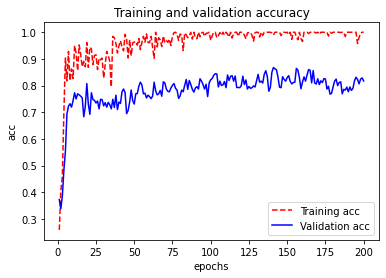

<Figure size 432x288 with 0 Axes>

In [18]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

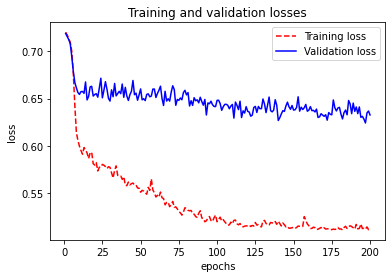

<Figure size 432x288 with 0 Axes>

In [19]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [20]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "Pesos Vgg16/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"Pesos Vgg16/LossesDataFrame.csv", index=False)

In [21]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
140,0.989796,0.867949
155,0.983333,0.864744
141,1.000000,0.862821
163,0.994792,0.860256
142,1.000000,0.858974
...,...,...
4,0.903401,0.553846
3,0.699858,0.483333
2,0.460256,0.385897
0,0.259115,0.373077


In [16]:
# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

In [70]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_180.pt')
#checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_140.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ("cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [71]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Pesos Vgg16/Submission.csv", index=False)

In [72]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[223  55]
 [ 58 205]]
------------Exactitud-------------------
0.7911275415896488
------------Precision-------------------
0.7910990789228006
[0.79359431 0.78846154]
------------Sensibilidad-------------------
0.7911275415896488
[0.80215827 0.77946768]
------------F1 score-------------------
0.7910889616591045
[0.79785331 0.78393881]
